In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%precision 2

'%.2f'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('bon', 4, 2)

In [4]:
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

In [5]:
from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)

In [6]:
tetrode_info = (
    make_tetrode_dataframe(ANIMALS)
    .loc[epoch_key]
    .set_index(['animal', 'day', 'epoch', 'tetrode_number'],
               drop=False))
tetrode_info

animal       area  day    depth descrip  \
animal day epoch tetrode_number                                           
bon    4   2     1                 bon        CA3    4  [[149]]     NaN   
                 2                 bon        CA3    4  [[151]]     NaN   
                 3                 bon        CA1    4  [[100]]     NaN   
                 4                 bon        CA1    4  [[107]]     NaN   
                 5                 bon        CA1    4  [[105]]     NaN   
                 6                 bon        NaN    4    [[0]]     NaN   
                 7                 bon        CA3    4  [[162]]     NaN   
                 8                 bon        CA3    4  [[154]]     NaN   
                 9                 bon        NaN    4      NaN     NaN   
                 10                bon        CA3    4  [[146]]     NaN   
                 11                bon        CA1    4   [[96]]     NaN   
                 12                bon        CA1    4  [[136]]     NaN   
                 13                bon        CA1    4   [[94]]     NaN   
                 14                bon        CA1    4   [[96]]     NaN   
                 15                bon        NaN    4    [[0]]     NaN   
                 16                bon        NaN    4      NaN     NaN   
                 17                bon        CA1    4  [[108]]     NaN   
                 18                bon        CA3    4  [[138]]     NaN   
                 19                bon        CA3    4  [[130]]     NaN   
                 20                bon        CA3    4  [[132]]     NaN   
                 21                bon        CA3    4  [[147]]     NaN   
                 22                bon        CA3    4  [[171]]     NaN   
                 23                bon        CA3    4  [[152]]     NaN   
                 24                bon        CA1    4  [[109]]     NaN   
                 25                bon        CA3    4  [[144]]     NaN   
                 26                bon        NaN    4      NaN     NaN   
                 27                bon        CA3    4  [[158]]     NaN   
                 28                bon        CA1    4  [[103]]     NaN   
                 29                bon        CA1    4  [[118]]     NaN   
                 30                bon  Reference    4    [[0]]     NaN   

                                 epoch hemisphere  maxcell  nearCA2  numcells  \
animal day epoch tetrode_number                                                 
bon    4   2     1                   2      right      1.0      0.0      10.0   
                 2                   2      right      NaN      0.0       5.0   
                 3                   2      right      NaN      0.0       0.0   
                 4                   2      right      NaN      0.0       2.0   
                 5                   2      right      NaN      0.0       5.0   
                 6                   2        NaN      NaN      NaN       0.0   
                 7                   2      right      NaN      0.0       2.0   
                 8                   2      right      NaN      0.0       0.0   
                 9                   2        NaN      NaN      NaN       NaN   
                 10                  2      right      NaN      0.0       4.0   
                 11                  2      right      NaN      0.0       6.0   
                 12                  2       left      NaN      0.0       4.0   
                 13                  2       left      NaN      0.0       4.0   
                 14                  2       left      1.0      0.0       8.0   
                 15                  2        NaN      NaN      NaN       0.0   
                 16                  2        NaN      NaN      NaN       NaN   
                 17                  2       left      NaN      0.0       2.0   
                 18                  2       left      NaN      0.0       7.0   
           

In [7]:
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1', 'CA3']) &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False) &
    tetrode_info.numcells > 0]

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

marks = [(get_mark_indicator_dataframe(tetrode_key, ANIMALS)
          .loc[:, mark_variables])
         for tetrode_key in hippocampal_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
         if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
             .shape[0]) != 0]

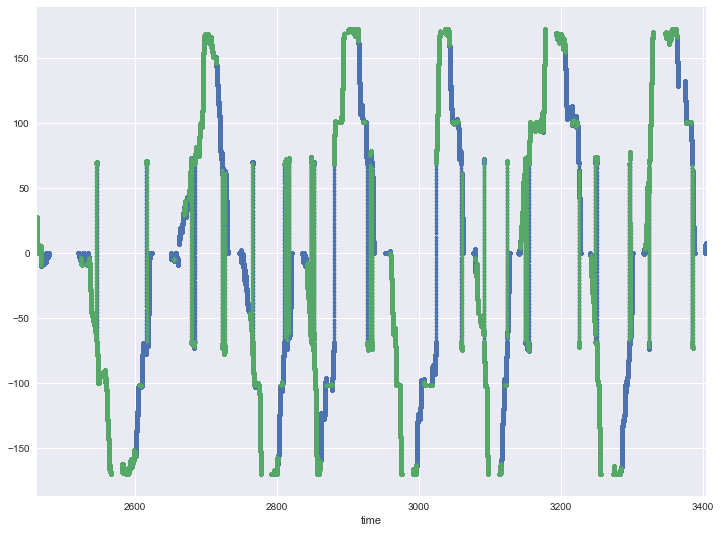

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12, 9))

position_info.linear_position.loc[
    (position_info.trajectory_direction == 'Inbound') &
    (position_info.speed > 4)
].plot(linestyle='None', marker='.', ax=ax);

position_info.linear_position.loc[
    (position_info.trajectory_direction == 'Outbound') &
    (position_info.speed > 4)
].plot(linestyle='None', marker='.', ax=ax);

In [9]:
position = position_info.loc[position_info.speed > 4].linear_position.values
spike_marks = np.stack(marks, axis=0)[:, (position_info.speed > 4).values, :]
trajectory_direction = position_info.loc[position_info.speed > 4].trajectory_direction.values

In [10]:
from src.ripple_decoding import ClusterlessDecoder

decoder = ClusterlessDecoder(
    position, np.ones_like(position), spike_marks,
    SAMPLING_FREQUENCY,
    replay_speedup_factor=33,
    observation_state_order=[1],
    state_transition_state_order=[1],
    state_names=['replay_position'],
    initial_conditions='Uniform',
    n_position_bins=61,
)
decoder.fit();

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
INFO:src.ripple_decoding.decoders:Fitting state transition model...
INFO:src.ripple_decoding.decoders:Fitting observation model...


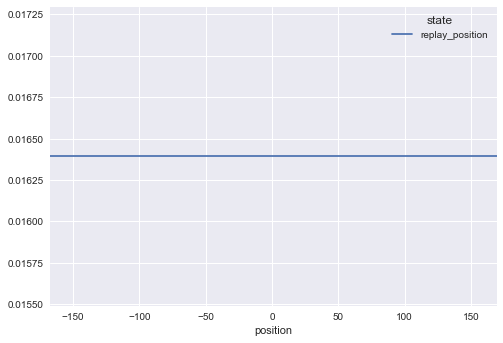

In [11]:
decoder.plot_initial_conditions();

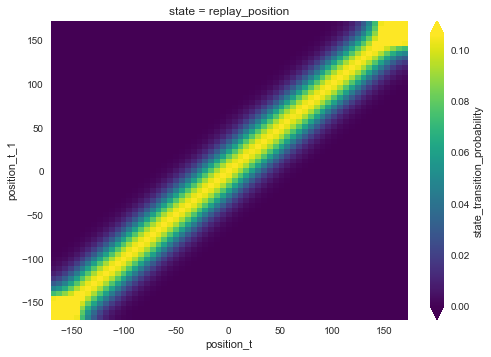

In [12]:
decoder.plot_state_transition_model();

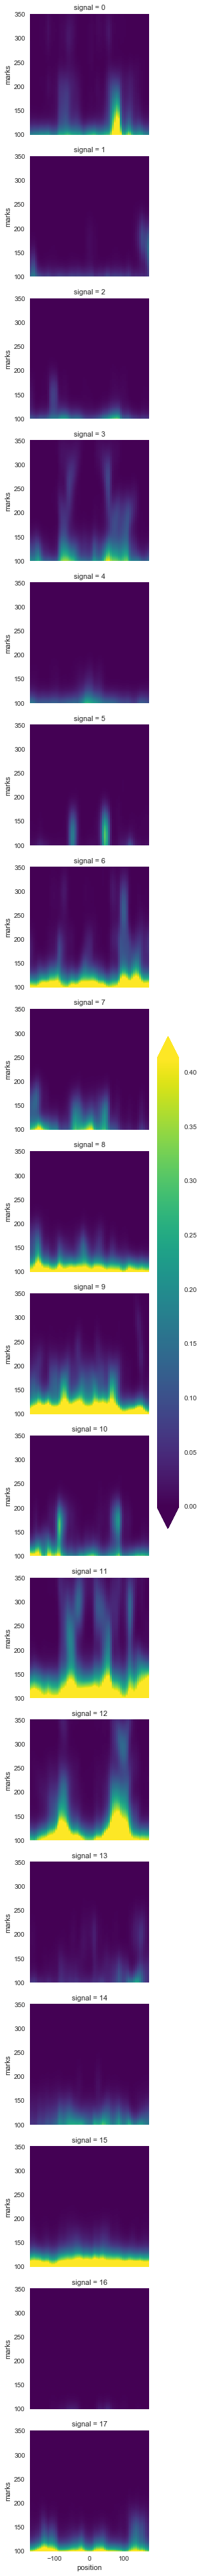

In [13]:
decoder.plot_observation_model();

In [14]:
ripple_times = np.array([[2790.730, 2791.069], [2570.073, 2570.246], [2947.943, 2948.179], [2585.179, 2585.421]])

In [15]:
from src.analysis import _get_ripple_marks

test_marks = _get_ripple_marks(
        marks, ripple_times, SAMPLING_FREQUENCY)

In [16]:
results = [decoder.predict(ripple_marks, time)
           for ripple_marks, time in test_marks]

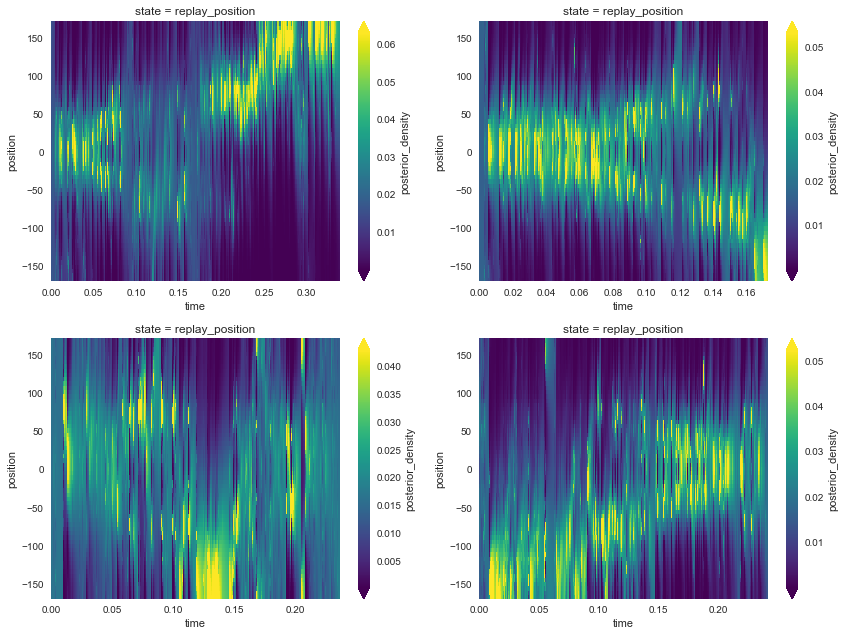

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
for ax, r in zip(axes.ravel().tolist(), results):
    r.posterior_density.squeeze().plot(ax=ax, x='time', y='position', robust=True)
plt.tight_layout()